# <a style='color:blue'>Classifiez automatiquement des biens de consommation         (Notebook 2: classification)

- <a href="#C11">1.1 Imports</a>
- <a href="#C12">1.2 Principes classification avec CNN Transfer Learning - VGG16</a>
- <a href="#C13">1.3 Preprocessing</a>
- <a href="#C14">1.4 Classification - modèle VGG16 sans data augmentation</a>
    - <a href="#C141">1.4.1 Définition du modèle</a>
    - <a href="#C142">1.4.2 Création et entrainement du modèle</a>
    - <a href="#C143">1.4.3 Evaluation du modèle</a>
- <a href="#C15">1.5 Classification - modèle VGG16 avec data augmentation</a>
    - <a href="#C151">1.5.1 Optimisation des hyperparamètres</a>
    - <a href="#C152">1.5.2 Définition du modèle</a>
    - <a href="#C153">1.5.3 Création et entrainement du modèle</a>
    - <a href="#C154">1.5.4 Evaluation du modèle</a>

# <a name="C11">1.1: Imports</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow as tf

# Keras - Preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # Encodage One-Hot

# Keras - Modélisation
from keras.applications.vgg16 import VGG16 #import du modèle VGG16 modèle fourni par Keras et pré-entraîné sur ImageNet
from keras.layers import Dense #permet de créer des couches fully-connected
from keras import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import * # GlobalAveragePooling2D()
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from plot_keras_history import show_history, plot_history

# Scikit-learn
from sklearn.model_selection import train_test_split

# TSNE
from sklearn.manifold import TSNE

# metrics
from sklearn import metrics

import time
import os
from os import listdir
import shutil

C:\Users\Vincent-Formation\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# <a name="C12">1.2 Principes classification avec CNN Transfer Learning - VGG16</a>

- Les CNN sont spécialement conçus pour traiter des images en entrée. Leur architecture est alors plus spécifique : elle est composée de deux blocs principaux.

- Le premier bloc fait la particularité de ce type de réseaux de neurones, puisqu'il fonctionne comme un extracteur de features. Pour cela, il effectue du template matching en appliquant des opérations de filtrage par convolution. La première couche filtre l'image avec plusieurs noyaux de convolution, et renvoie des "feature maps", qui sont ensuite normalisées (avec une fonction d'activation) et/ou redimensionnées.

- Le second bloc n'est pas caractéristique d'un CNN : il se retrouve en fait à la fin de tous les réseaux de neurones utilisés pour la classification. Les valeurs du vecteur en entrée sont transformées (avec plusieurs combinaisons linéaires et fonctions d'activation) pour renvoyer un nouveau vecteur en sortie. Ce dernier vecteur contient autant d'éléments qu'il y a de classes : l'élément i
 représente la probabilité que l'image appartienne à la classe i
. Chaque élément est donc compris entre 0 et 1, et la somme de tous vaut 1. Ces probabilités sont calculées par la dernière couche de ce bloc (et donc du réseau), qui utilise une fonction logistique (classification binaire) ou une fonction softmax (classification multi-classe) comme fonction d'activation.

- Comme pour les réseaux de neurones ordinaires, les paramètres des couches sont déterminés par rétropropagation du gradient : l'entropie croisée est minimisée lors de la phase d'entraînement. Mais dans le cas des CNN, ces paramètres désignent en particulier les features des images.    

Transfer learning:
- Le Transfer Learning (ou apprentissage par transfert) permet de faire du Deep Learning sans avoir besoin d'y passer un mois de calculs. Le principe est d'utiliser les connaissances acquises par un réseau de neurones lors de la résolution d'un problème afin d'en résoudre un autre plus ou moins similaire. On réalise ainsi un transfert de connaissances, d'où le nom.

- En plus d'accélérer l'entraînement du réseau, le Transfer Learning permet d'éviter le sur-apprentissage (overfitting). En effet, lorsque la collection d'images en entrée est petite, il est vivement déconseillé d'entraîner le réseau de neurones en partant de zéro (c'est-à-dire avec une initialisation aléatoire) : le nombre de paramètres à apprendre étant largement supérieur au nombre d'images, le risque d'overfitting est énorme !
    
- Le Transfer Learning est une technique très utilisée en pratique et simple à mettre en œuvre. Elle nécessite d'avoir un réseau de neurones déjà entraîné, de préférence sur un problème proche de celui qu'on veut résoudre. De nos jours, nous pouvons facilement en récupérer un sur Internet, et notamment dans les bibliothèques de Deep Learning, comme Keras

- Réseau VGG-16 fourni par Keras. VGG16 est pré-entrainé avec ImageNet

- Transfer Learning

- 3 strategies possibles:
    - fine-tuning total
   
    - **extraction des features => stratégie choisie**
    
    - fine-tuning partiel

# <a name="C13">1.3 Preprocessing</a>

Préparation initiale de l'ensemble des images avant classification supervisée

In [2]:
# Import du nom des images avec leur catégorie
data=pd.read_csv('data_category.csv')

In [3]:
path_train = "Images_train/"
path_test= "Images_test/"

list_images_train = [file for file in listdir(path_train)]
list_images_test = [file for file in listdir(path_test)]

list_labels=["Baby Care", "Watches", "Home Furnishing", "Home Decor & Festive Needs", "Kitchen & Dining", "Beauty and Personal Care", "Computers"]

In [4]:
def get_cat (image_name):
    '''
    Fonction qui retourne la catégorie d'une image (valeur entre 0 et 6)
    '''
    cat=data.loc[data['uniq_id'] ==image_name, 'category_numeric_true'].values[0]
    return cat

In [5]:
def data_fct(path) :
    '''
    Fonction qui permet de récupérer les catégorie des images d'un répertoire
    '''
    list_photos = [file for file in listdir(path)]
    print(len(list_photos))
    data1 = pd.DataFrame()
    data1["image_path"] = list_photos
    data1["label"] = data1["image_path"].apply(lambda x : get_cat(x))
    return data1

data_train = data_fct(path_train)
data_test = data_fct(path_test)

800
250


In [6]:
def image_prep_fct(path) :
    '''
    Fonction de preprocessing
    - Chargement des images
    - Redimensionnement en 224x224 
    - Conversion en array numpy
    '''
    prepared_images = []
    for image_num in listdir(path) :
        img = (load_img(path+image_num, target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        #img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct("Images_train/")
print(images_np.shape)
images_np_test = image_prep_fct("Images_test/")
print(images_np_test.shape)

C:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(800, 224, 224, 3)
(250, 224, 224, 3)


In [7]:
# Encodage one-hot des étiquettes catégorielles sous forme de vecteurs binaires.
X = images_np
y = to_categorical(data_train['label']) 

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
# Séparation en jeu de train et jeu de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(600, 224, 224, 3)

# <a name="C14">1.4 Classification - modèle VGG16 sans data augmentation</a>

# <a name="C141">1.4.1 Définition du modèle</a>

- Stratégie d’extraction de features lors du transfert d’apprentissage avec le modèle VGG-16

- Utilisation des poids pré-entraînés du modèle VGG-16 jusqu’à la dernière couche de convolution, mais nous excluons les couches fully-connected.
    

In [9]:
def create_model_fct() :
    # Récupérer le modèle VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected (couches de sortie)
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3)) #La suppression des dernières couches avec (include_top=False)

    # Layer non entraînables = on garde les poids du modèle pré-entraîné. # Stratégie #2 : extraction de features: On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x) #couche de Global Average Pooling est ajoutée pour réduire la dimensionnalité des features
    x = Dense(256, activation='relu')(x) #Une couche fully-connected avec 256 neurones et une fonction d’activation ReLU est ajoutée.
    x = Dropout(0.5)(x) #Une couche de dropout avec un taux de 0,5 est insérée pour prévenir le surapprentissage
    # Ajouter la nouvelle couche fully-connected avec 7 neurones pour la classification à 7 classes
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

# <a name="C142">1.4.2 Création en entrainement du modèle</a>

In [10]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks_list = [checkpoint, es]




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [11]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1 = time.time()
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
duration1=time.time()-temps1
print("temps de train modèle 1: ", "%15.2f" % duration1, "secondes")

Epoch 1/50


19/19 [==============================] - ETA: 0s - loss: 5.5947 - accuracy: 0.4817
Epoch 1: val_loss improved from inf to 1.30378, saving model to .\model1_best_weights.h5
19/19 [==============================] - 44s 2s/step - loss: 5.5947 - accuracy: 0.4817 - val_loss: 1.3038 - val_accuracy: 0.7400
Epoch 2/50


C:\Users\Vincent-Formation\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - ETA: 0s - loss: 1.8548 - accuracy: 0.6900
Epoch 2: val_loss did not improve from 1.30378
19/19 [==============================] - 42s 2s/step - loss: 1.8548 - accuracy: 0.6900 - val_loss: 1.3377 - val_accuracy: 0.7650
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.2007 - accuracy: 0.7550
Epoch 3: val_loss improved from 1.30378 to 0.98857, saving model to .\model1_best_weights.h5
19/19 [==============================] - 42s 2s/step - loss: 1.2007 - accuracy: 0.7550 - val_loss: 0.9886 - val_accuracy: 0.7950
Epoch 4/50
19/19 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.8050
Epoch 4: val_loss improved from 0.98857 to 0.91417, saving model to .\model1_best_weights.h5
19/19 [==============================] - 43s 2s/step - loss: 0.8107 - accuracy: 0.8050 - val_loss: 0.9142 - val_accuracy: 0.7850
Epoch 5/50
19/19 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.8517
Epoch 5: val_lo

# <a name="C143">1.4.3 Evaluation du modèle</a>

In [12]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_train, y_train, verbose=False)
print("Train Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

print("temps de train du modèle 1: ", "%15.2f" % duration1, "secondes")

Train Accuracy :  0.9500
Validation Accuracy :  0.7850
Test Accuracy       :  0.7160
temps de train du modèle 1:           253.50 secondes


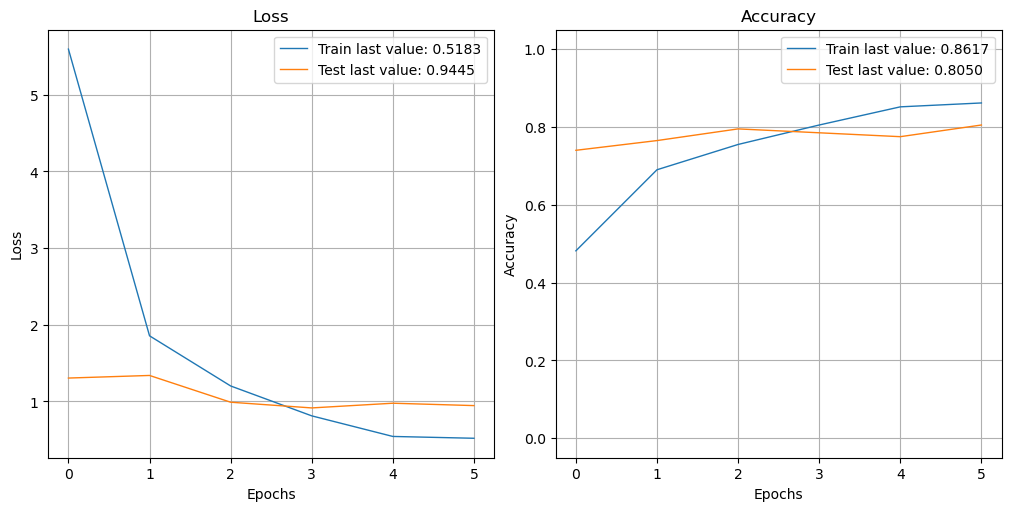

In [13]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [14]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 11s 1s/step
[6 0 6 5 1 1 5 6 1 5 4 6 0 3 3 2 5 0 1 0 4 0 3 4 6 4 5 4 3 6 5 0 4 3 4 2 3
 2 4 6 1 3 0 5 4 5 6 6 1 4 3 6 3 4 5 1 1 2 3 1 0 2 5 0 5 4 6 1 2 5 3 0 6 2
 4 3 2 4 5 4 1 1 0 2 0 2 4 1 5 3 5 3 2 1 2 4 3 0 1 6 0 3 4 6 4 1 0 5 1 3 5
 2 0 2 0 1 3 0 5 1 5 2 2 3 3 1 6 2 6 5 0 2 2 1 3 6 2 6 5 1 5 2 0 5 3 1 0 3
 1 2 4 0 4 2 2 6 2 4 6 2 3 1 1 1 6 6 5 0 6 3 1 4 1 0 3 6 2 4 1 6 4 4 4 0 5
 5 5 4 6 0 5 0 5 3 6 6 3 3 0 0]

[6 0 6 5 1 1 5 6 1 5 4 2 0 3 3 2 5 0 1 0 4 0 3 4 6 4 5 4 3 6 5 4 0 3 4 2 2
 2 0 6 1 0 0 5 4 5 6 3 1 4 1 6 3 4 3 1 1 2 3 1 0 0 5 2 5 4 4 1 2 5 3 0 2 0
 4 3 2 4 6 4 1 1 0 2 0 0 4 1 5 5 4 3 4 1 2 4 3 0 1 6 0 3 4 5 4 1 6 5 1 1 5
 2 0 3 2 1 3 4 5 1 4 0 2 3 3 1 6 2 3 5 0 0 0 1 3 6 2 6 5 1 5 2 4 5 3 1 0 0
 1 2 4 0 4 2 5 6 2 4 6 2 3 1 1 1 6 6 5 0 3 4 1 4 1 0 4 5 2 0 6 6 4 4 4 0 5
 0 5 4 6 0 5 3 6 3 6 6 3 3 0 2]


In [15]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[21  0  3  1  3  0  1]
 [ 0 29  0  0  0  0  1]
 [ 6  0 18  1  1  1  0]
 [ 2  2  1 21  2  1  0]
 [ 3  0  0  0 25  0  0]
 [ 1  0  0  1  2 23  2]
 [ 0  0  2  3  1  2 20]]


In [16]:
print(metrics.classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       0.64      0.72      0.68        29
           1       0.94      0.97      0.95        30
           2       0.75      0.67      0.71        27
           3       0.78      0.72      0.75        29
           4       0.74      0.89      0.81        28
           5       0.85      0.79      0.82        29
           6       0.83      0.71      0.77        28

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.78       200



<Axes: >

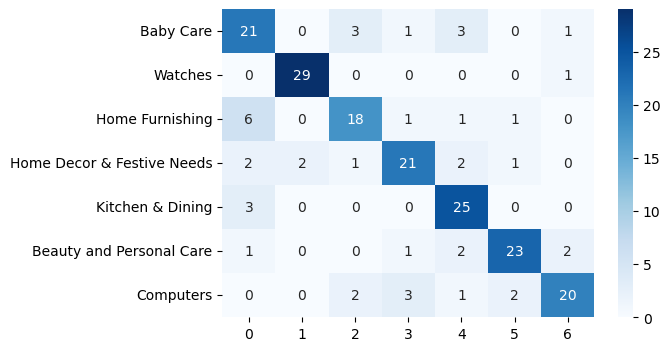

In [17]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# <a name="C15">1.5 Classification - modèle VGG16 avec data augmentation</a>

- Stratégie d’extraction de features lors du transfert d’apprentissage avec le modèle VGG-16

- Utilisation des poids pré-entraînés du modèle VGG-16 jusqu’à la dernière couche de convolution, mais nous excluons les couches fully-connected.

- Une augmentation de données est mise en place à l’aide de la séquence data_augmentation. Cela permet de générer des variations des images d’entraînement en appliquant des transformations telles que des retournements horizontaux, des rotations et des zooms

# <a name="C151">1.5.1 Optimisation des hyperparamètres</a>

Nous avons entrainé et évalué le modèle avec data augmentation en optimisant les hyperparamètres suivants:
    
- Optimizer='Adam' et 'rmsprop' => 'rmsprop'

- RandomFlip='Horizontal' ou 'horizontal_and_vertical' => 'Horizontal'

- RandomRot=0.1 et 0.2 => 0.1

- RandomZoom=0.1 et 0.2 => 0.1

- Rescaling: (1./127.5, offset=-1.0) ou 1./255 => (1./127.5, offset=-1.0) 

- Dropout=0.5 et 0.2 => 0.5

- EarlyStop Patience=5 et 2 => 5

- batch_size=32 et 64 => 32

    
    

# <a name="C152">1.5.2 Définition du modèle</a>

In [18]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)), # testé avec "horizontal"
        RandomRotation(0.1), #test 0.2
        RandomZoom(0.1),  #test (0.2, 0.2) height_factor, width_factor
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1.0), #Test Rescaling(1./255),   # Rescale an input in the [0, 255] range to be in the [0, 1] => ENLEVER OFFSET= -1
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),  ##### Test 0.2 use a small dropout value of 20%-50% of neurons, with 20% providing a good starting point. A probability too low has minimal effect, and a value too high results in under-learning by the network.
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    #model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

# <a name="C153">1.5.3 Création en entrainement du modèle</a>

In [19]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct2()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [20]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps2 = time.time()
with tf.device('/gpu:0'): 
    history2 = model2.fit(X_train, y_train, epochs=50, batch_size=32, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
duration2=time.time()-temps2

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 1.7360 - accuracy: 0.3333
Epoch 1: val_loss improved from inf to 1.27131, saving model to .\model2_best_weights.h5
19/19 [==============================] - 47s 2s/step - loss: 1.7360 - accuracy: 0.3333 - val_loss: 1.2713 - val_accuracy: 0.6900
Epoch 2/50


C:\Users\Vincent-Formation\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - ETA: 0s - loss: 1.3000 - accuracy: 0.5833
Epoch 2: val_loss improved from 1.27131 to 1.00907, saving model to .\model2_best_weights.h5
19/19 [==============================] - 44s 2s/step - loss: 1.3000 - accuracy: 0.5833 - val_loss: 1.0091 - val_accuracy: 0.7400
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 1.1257 - accuracy: 0.6450
Epoch 3: val_loss improved from 1.00907 to 0.85858, saving model to .\model2_best_weights.h5
19/19 [==============================] - 46s 2s/step - loss: 1.1257 - accuracy: 0.6450 - val_loss: 0.8586 - val_accuracy: 0.7950
Epoch 4/50
19/19 [==============================] - ETA: 0s - loss: 0.9917 - accuracy: 0.6867
Epoch 4: val_loss improved from 0.85858 to 0.83296, saving model to .\model2_best_weights.h5
19/19 [==============================] - 46s 2s/step - loss: 0.9917 - accuracy: 0.6867 - val_loss: 0.8330 - val_accuracy: 0.7500
Epoch 5/50
19/19 [==============================] - ETA: 0s - l

# <a name="C154">1.5.4 Evaluation du modèle</a>

In [21]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Train Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

print("temps de train du modèle 2: ", "%15.2f" % duration2, "secondes")

Train Accuracy :  0.8867
Validation Accuracy :  0.8200
Test Accuracy       :  0.7680
temps de train du modèle 2:           973.19 secondes


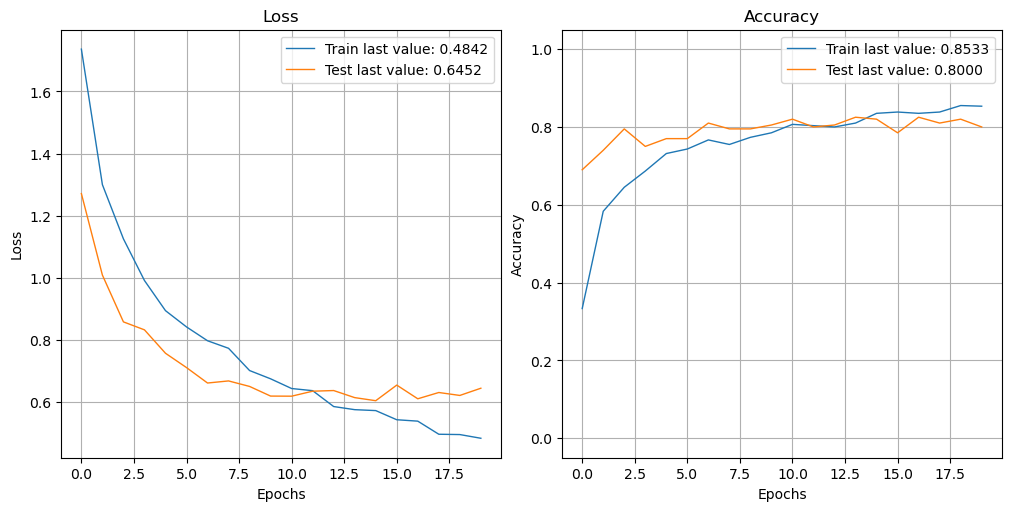

In [22]:
show_history(history2)
plot_history(history2, path="standard2.png")
plt.close()

In [23]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model2.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 12s 2s/step
[6 0 6 5 1 1 5 6 1 5 4 6 0 3 3 2 5 0 1 0 4 0 3 4 6 4 5 4 3 6 5 0 4 3 4 2 3
 2 4 6 1 3 0 5 4 5 6 6 1 4 3 6 3 4 5 1 1 2 3 1 0 2 5 0 5 4 6 1 2 5 3 0 6 2
 4 3 2 4 5 4 1 1 0 2 0 2 4 1 5 3 5 3 2 1 2 4 3 0 1 6 0 3 4 6 4 1 0 5 1 3 5
 2 0 2 0 1 3 0 5 1 5 2 2 3 3 1 6 2 6 5 0 2 2 1 3 6 2 6 5 1 5 2 0 5 3 1 0 3
 1 2 4 0 4 2 2 6 2 4 6 2 3 1 1 1 6 6 5 0 6 3 1 4 1 0 3 6 2 4 1 6 4 4 4 0 5
 5 5 4 6 0 5 0 5 3 6 6 3 3 0 0]

[6 0 6 5 1 1 5 6 1 5 4 1 0 3 3 2 5 0 1 0 4 0 3 4 6 6 5 4 3 6 5 4 0 3 4 2 2
 2 0 6 1 3 0 5 4 5 6 4 1 4 1 6 3 4 6 1 1 0 3 1 0 0 5 2 5 4 6 1 2 5 3 0 6 0
 4 3 2 4 6 4 1 1 2 2 0 2 4 1 5 3 5 3 0 1 2 4 3 0 1 6 0 3 4 5 4 1 6 5 1 3 5
 2 0 2 2 1 3 6 5 1 4 0 2 3 3 1 4 3 3 5 0 2 2 1 3 6 2 6 5 1 5 2 0 5 3 1 0 3
 1 2 4 0 4 2 0 6 2 4 6 2 3 1 1 1 6 6 4 0 3 4 1 4 1 0 3 5 2 0 6 6 6 4 4 0 5
 6 5 4 6 0 5 3 6 3 6 6 3 3 0 0]


In [24]:
conf_mat2 = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat2)

[[22  0  3  1  1  0  2]
 [ 0 29  0  0  0  0  1]
 [ 6  0 20  1  0  0  0]
 [ 0  1  1 26  1  0  0]
 [ 3  0  0  0 23  0  2]
 [ 0  0  0  0  2 23  4]
 [ 0  1  0  2  2  2 21]]


In [25]:
print(metrics.classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73        29
           1       0.94      0.97      0.95        30
           2       0.83      0.74      0.78        27
           3       0.87      0.90      0.88        29
           4       0.79      0.82      0.81        28
           5       0.92      0.79      0.85        29
           6       0.70      0.75      0.72        28

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



<Axes: >

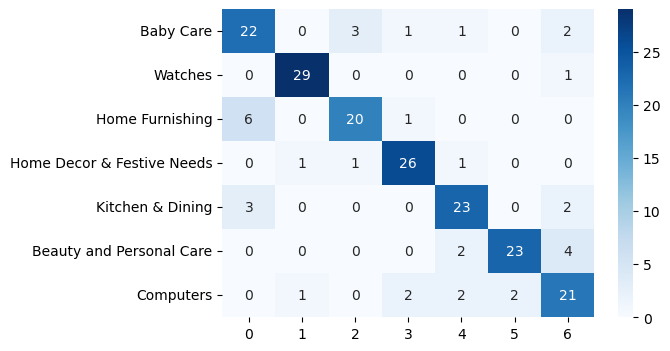

In [26]:
df_cm2 = pd.DataFrame(conf_mat2, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm2, annot=True, cmap="Blues")